# Download regional llc4320 simulation output

This notebook downloads one or more daily files of ECCO-BASED PRE-SWOT NUMERICAL SIMULATION data. The dataset can be found following https://search.earthdata.nasa.gov/search?q=pocloud%20pre-swot.

User specifies the region of interest and number of files to download. Options are (see [this site](ttps://podaac.jpl.nasa.gov/datasetlist?ids=Processing+Levels&values=4+-+Gridded+Model+Output&search=Pre-SWOT+llc4320&view=list&provider=)):

- WesternMed  
- ROAM_MIZ  
- NewCaledonia  
- NWPacific  
- BassStrait  
- RockallTrough  
- ACC_SMST 
- MarmaraSea  
- LabradorSea  
- CapeBasin

Code adapted from [PRE-SWOT NUMERICAL SIMULATION VERSION 1 User Guide Demo](https://github.com/podaac/tutorials/blob/master/notebooks/Pre-SWOT_Numerical_Simulation_Demo.ipynb) written by Jinbo Wang <Jinbo.Wang@jpl.nasa.gov>, Jack McNelis <jack.mcnelis@jpl.nasa.gov>

In [2]:
import os
# import s3fs
import requests
import xarray as xr
import pylab as plt
from netrc import netrc
from urllib import request
from platform import system
from getpass import getpass
from http.cookiejar import CookieJar
from os.path import expanduser, join
import datetime

In [3]:
# --------------------------------------------------------------------
# USER INPUTS:
# specify region from this list:
# WesternMed  ROAM_MIZ  NewCaledonia  NWPacific  BassStrait  RockallTrough  ACC_SMST
# MarmaraSea  LabradorSea  CapeBasin
RegionName = 'ACC_SMST' 
# specify date range as start date & number of days.
start_date = datetime.date(2012,1,1)
ndays = 31


# ---------------------------------------------------------------------
ShortName = "MITgcm_LLC4320_Pre-SWOT_JPL_L4_" + RegionName + "_v1.0"
date_list = [start_date + datetime.timedelta(days=x) for x in range(ndays)]
target_files = [f'LLC4320_pre-SWOT_{RegionName}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
# directory to store netcdf files.
# datadir = './data/' # default is ./data
datadir = '/data1/adac/mitgcm/netcdf/' + RegionName +'/'

**Earthdata Login**

Authenticate with your Earthdata Login/URS credentials by configuring a *.netrc* file in your home directory.

```
machine urs.earthdata.nasa.gov username myusername password mypassword
```

>*Note this next cell first tries to establish in-region acccess to the netCDF file in S3. (It assumes that you are running the notebook inside AWS EC2 in the `aws-west-2` region.) Upon failure, it assumes that you are running from your local machine, and so it tries to download and open the file the normal way.*

Run the next cell to authenticate. (You might be prompted for your Earthdata Login username and password.)

In [4]:
def setup_earthdata_login_auth(endpoint: str='urs.earthdata.nasa.gov'):
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        print('Please provide your Earthdata Login credentials for access.')
        print('Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass('Password: ')
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)
    
setup_earthdata_login_auth()

You should now be able to download the file at the following link:

In [5]:
# https access for each target_file
url = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected"
https_accesses = [f"{url}/{ShortName}/{target_file}" for target_file in target_files]
print(https_accesses)

['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MITgcm_LLC4320_Pre-SWOT_JPL_L4_ACC_SMST_v1.0/LLC4320_pre-SWOT_ACC_SMST_20120126.nc']


**Open the dataset**

Run the next cell to access/open the netCDF file with *xarray*:

In [10]:
def begin_s3_direct_access():
    """Returns s3fs object for accessing datasets stored in S3."""
    response = requests.get("https://archive.podaac.earthdata.nasa.gov/s3credentials").json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'], 
                             client_kwargs={'region_name':'us-west-2'})

# list of dataset objects
dds = []
for https_access,target_file in zip(https_accesses,target_files):
    print(target_file) # print file name

    # try to read from AWS and append to dds
    try:
        fs = begin_s3_direct_access()
        # Load netCDF with 's3fs' and 'xarray' upon successful connection to S3:
        dds.append(xr.open_dataset(fs.open(f"podaac-ops-cumulus-protected/{ShortName}/{target_file}")))
    # if not on AWS, it will download data
    except:
        if not(os.path.isfile(datadir + target_file)):
            print("Failed to establish AWS in-region access. Downloading to local disk instead.")
            filename_dir = os.path.join(datadir, target_file)
            request.urlretrieve(https_access, filename_dir)
        else:
            print('>> File exists on local disk - skipping')

LLC4320_pre-SWOT_ACC_SMST_20120126.nc
Failed to establish AWS in-region access. Downloading to local disk instead.


In [ ]:
# if dds is empty (which means we are not on AWS)
if dds==[]: 
    # Load all netCDF files
    dds = xr.open_mfdataset(target_files)
else:
    # Concatenate all files loaded from AWS
    dds = xr.concat(dds,'time')

Plot eight 2D fields.
-------------------

In [16]:
# select the first time step for plotting
dd0 = dds.isel(time=0).load()

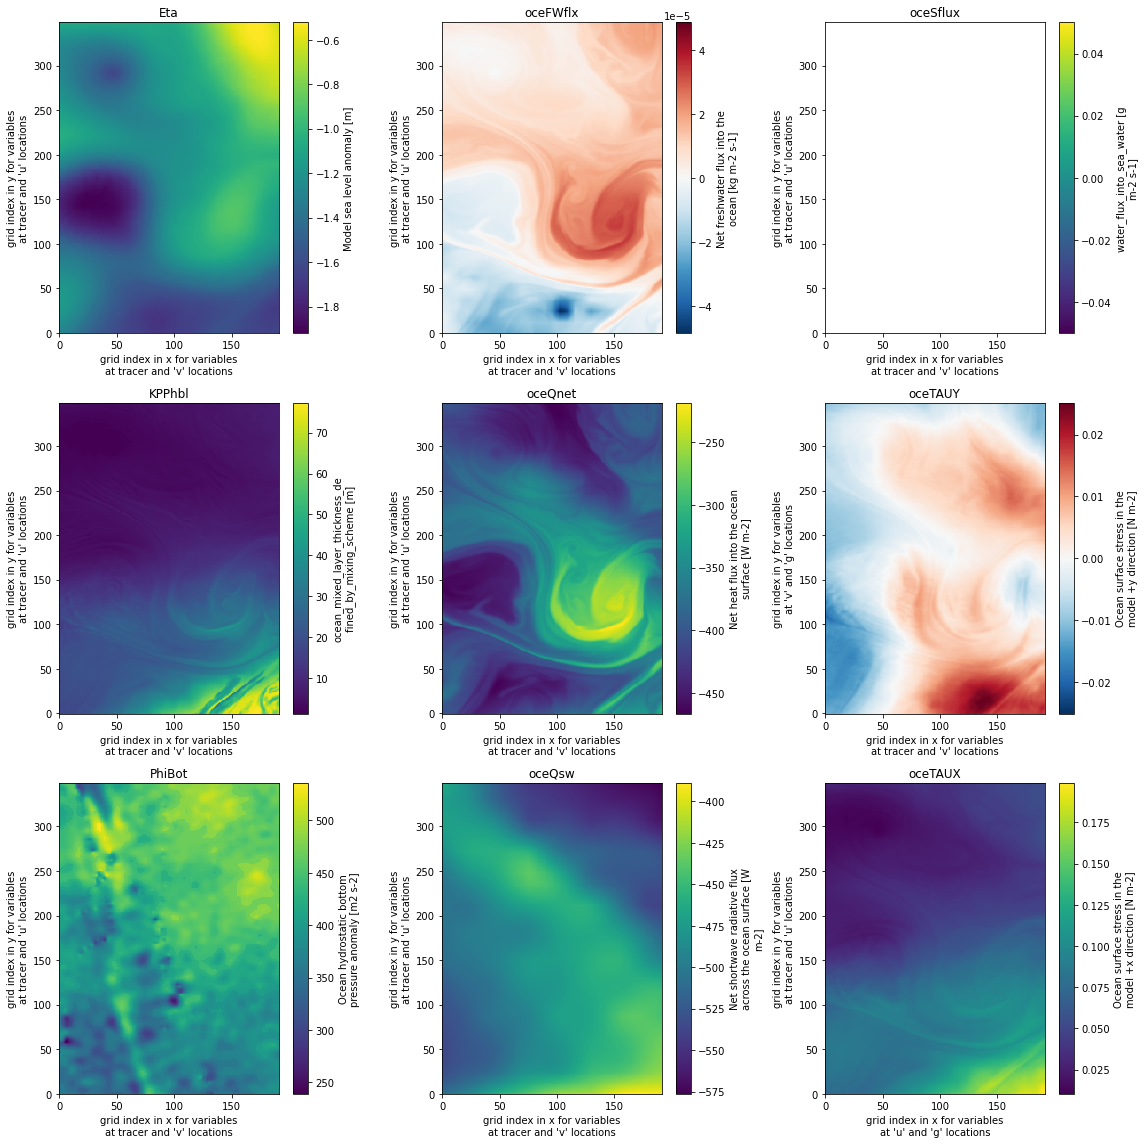

In [17]:
fig,ax=plt.subplots(3,3,figsize=(16,16))

varn=['Eta','KPPhbl','PhiBot','oceFWflx','oceQnet','oceQsw','oceSflux','oceTAUY','oceTAUX']

for i in range(3):
    for j in range(3):
        dd0[varn[i*3+j]].plot(ax=ax[j,i])
        ax[j,i].set_title(varn[i*3+j])
plt.tight_layout()

Plot a 3D field based (temperature)
---------------------------------

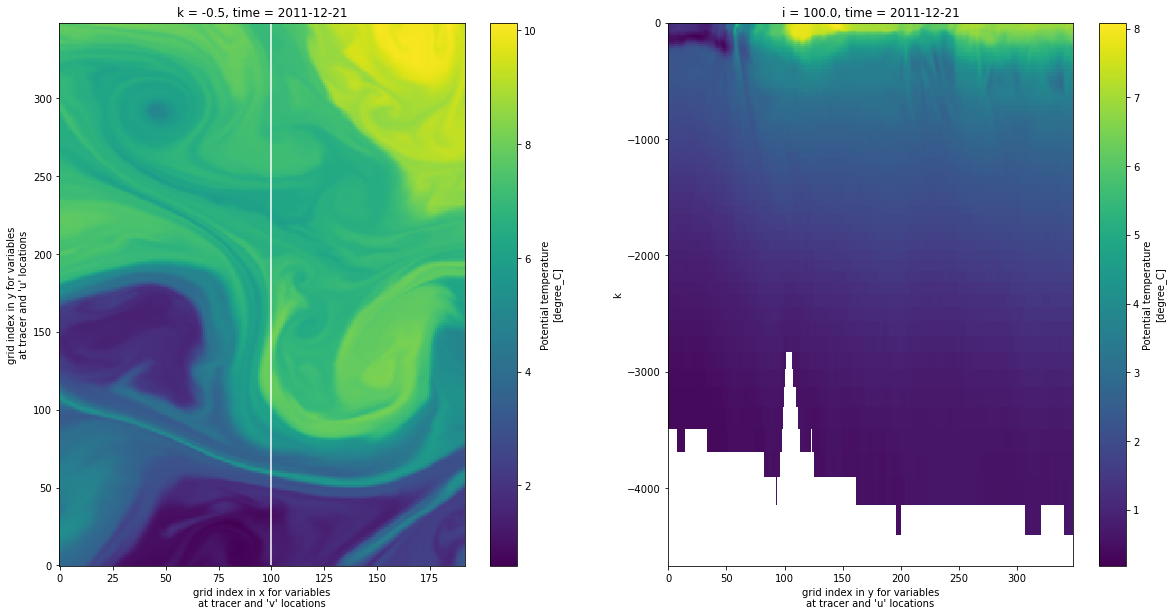

In [18]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
theta=dd0['Theta'][:]
theta.coords['k']=dd0['Z'].data

theta[0,...].plot(ax=ax[0])
ax[0].vlines(100,0,400,colors='w')
theta[:,:,100].plot(ax=ax[1])